# Segmentation MoNuSeg data with Unet fast.ai

Nuclei segmentation of stained tissue images of tumor patients in MICCAI2018 [challenge](https://monuseg.grand-challenge.org/Data/). The data contains about 30 images and a corresponding mask. Use fast.ai and Unet architectures to do nuclei segmentation. 

The training dataset contain images and the mask file in XML. My teammate convert the XML files into a mask with different color setting. I started working with the image and the mask files directly. 

With just 30 images, it is difficult to train a NN. Luckily, the images are large 1000 x 1000 pixels; therefore I cut the images and the masks into 125 x 125 images and upsampling to 128 x 128 images. This give me, 1920 images. 

Next, convert the mask files from three channel color images to black and white images.

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2


from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

torch.cuda.set_device(0)
torch.backends.cudnn.enabled
torch.cuda.is_available()

/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


True

## Data Exploration and Resize images

In [3]:
path = "data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/"
path_tissue=path+ 'TissueImages/'
path_mask=path+ 'LabeledNucImages/'

In [4]:
!ls {path}

Annotations
GenerateMask_for_MoNuSeg.ipynb
LabeledNucImages
NucCentroids
TissueImages
bwmask125
generate_binary_mask.m
he_to_binary_mask_final.m
mask125
mask250
mask500
tissue125
tissue250
tissue500
torch_models


In [ ]:
filenames= glob.glob(path_tissue+'*.tif')
filenames= [os.path.basename(x) for x in filenames]
img=plt.imread(f'{path_tissue}'+filenames[0])

In [14]:
img.size

(1000, 1000)

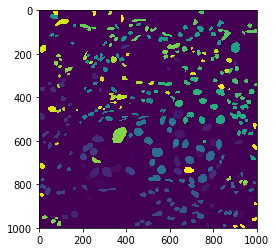

In [27]:
mask_filenames=os.listdir(path_mask)

img_mask = Image.open(f'{path_mask}'+mask_filenames[0]);
plt.imshow(img_mask)

In [26]:
img_mask.mode

'RGBA'

In [28]:
img_mask.size

(1000, 1000)

## Croping images and save them into 500 pixelsfolders

In [27]:
os.mkdir(f'{path}'+'tissue-500')
os.mkdir(f'{path}'+'mask-500')

In [30]:
!ls {path}

Annotations	  mask-500	tissue-500    torch_models
LabeledNucImages  NucCentroids	TissueImages


In [28]:
filename=filenames[0]
filename[:12]

'TCGA-18-5592'

In [3]:
import imageio
import skimage.io as io

## Image Segmentation

In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [3]:
path = "data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/"

path_wsi=path+'tissue128/'
path_mask=path+'mask128/'
path_bwmask=path+'bwmask128/'

In [5]:
wsi_names=glob.glob(path_wsi+'*.tif')
mask_names=glob.glob(path_bwmask+'*.tif')

In [382]:
!ls {path}

Annotations  LabeledNucImages  mask500	     tissue250
bwmask125    mask125	       NucCentroids  tissue500
bwmask128    mask128	       tissue125     TissueImages
bwmask250    mask250	       tissue128     torch_models


In [7]:
#len(wsi_names)
len(mask_names)

1920

In [8]:
img=cv2.imread(wsi_names[2])

In [9]:
img.shape

(128, 128, 3)

In [10]:
wsi_names[:5]

['data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/tissue128/TCGA-49-4488-032.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/tissue128/TCGA-B0-5698-101.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/tissue128/TCGA-DK-A2I6-012.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/tissue128/TCGA-G2-A2EK-213.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/tissue128/TCGA-NH-A8F7-232.tif']

In [9]:
mask_names[:5]

['data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask125/TCGA-49-4488-032.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask125/TCGA-B0-5698-101.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask125/TCGA-DK-A2I6-012.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask125/TCGA-G2-A2EK-213.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask125/TCGA-NH-A8F7-232.tif']

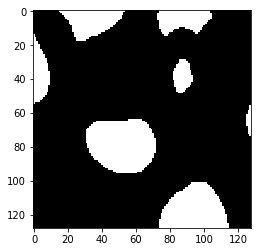

In [19]:
mask=open_image(mask_names[2]); 
plt.imshow(mask)

In [20]:
mask.shape

(128, 128, 3)

In [21]:
np.max(mask), np.min(mask),type(mask)

(1.0, 0.0, numpy.ndarray)

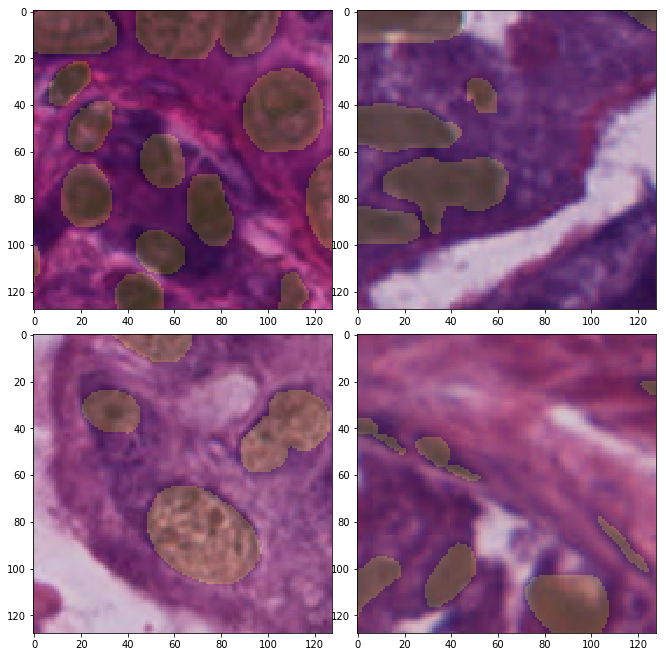

In [10]:
_, axes = plt.subplots(2, 2, figsize=(9, 9))
for i,ax in enumerate(axes.flat):
    #pdb.set_trace()
    img=plt.imread(wsi_names[i*4])
    ax.imshow(img)
    mask=plt.imread(mask_names[i*4]); 
    ax.imshow(mask, alpha=0.2) 
plt.tight_layout(pad=0.1)
             

## Dataloader

In [22]:
#find the mean and std of each image 
wsimean =[]
wsistd=[]

for file in wsi_names:
    img=plt.imread(file)
    wsimean.append((np.mean(img[:,:,0]),np.mean(img[:,:,1]),np.mean(img[:,:,2])))
    wsistd.append((np.std(img[:,:,0]),np.std(img[:,:,1]),np.std(img[:,:,2])))
    

In [23]:
n=len(wsi_names)
val_idxs = get_cv_idxs(n)
val_idxs[:5]

array([ 998, 1621,  611,  514,  413])

In [24]:
val_x= [wsi_names[o] for o  in val_idxs]
trn_x = [wsi_names[o] for o  in range(n) if o not in val_idxs]

val_y=  [mask_names[o] for o  in val_idxs]
trn_y = [mask_names[o] for o  in range(n) if o not in val_idxs]

In [61]:
wsi_allmean_trn = np.mean([wsimean[i] for i in range(n) if i not in val_idxs],axis=0)
wsi_allstd_trn = np.std([wsistd[i] for i in range(n) if i not in val_idxs],axis=0)

In [62]:
stats = (wsi_allmean_trn,wsi_allstd_trn)
stats

(array([172.04525, 120.12683, 158.12321]),
 array([11.52106, 13.41745, 10.52536]))

In [25]:
#this function does nothing just to help fast ar ImageData.get_ds to return a dataset. 
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [31]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [63]:
def get_data(sz,bs):
    tfms = tfms_from_model(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    #dataloader has continuous=True option for regression model 
    #Treat this problem as a classification 
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    data = ImageData('', datasets, bs, num_workers=8, classes=None)
    return data

In [64]:
data = get_data(128,32)

In [68]:
x,y = next(iter(data.trn_dl))
x.shape,y.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 128, 128]))

In [69]:
x = data.trn_ds.denorm(x)

In [70]:
x.shape

(32, 128, 128, 3)

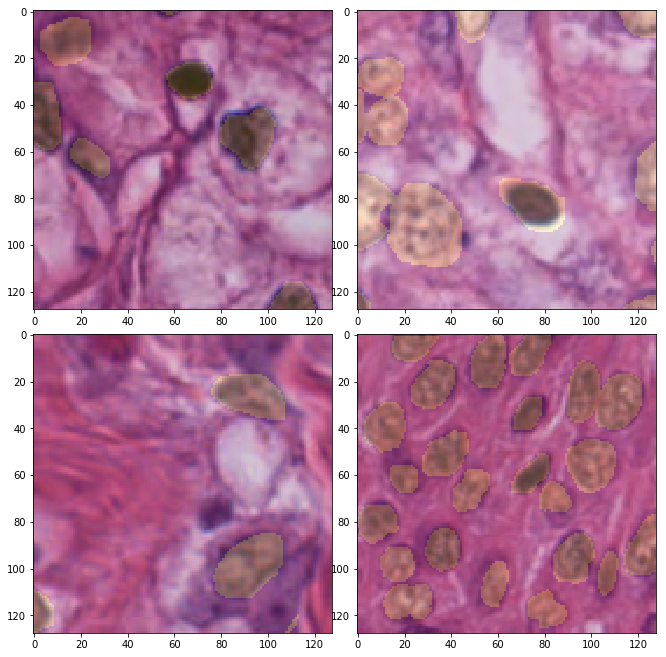

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
for i,ax in enumerate(axes.flat):
    #pdb.set_trace()
    ax.imshow(x[i*4])
    ax.imshow(y[i*4], alpha=0.2) 
plt.tight_layout(pad=0.1)

## Unet 128 size

In [39]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [40]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [41]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [42]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [46]:
f = resnet34
cut,lr_cut = model_meta[f]
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [47]:

m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [48]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [49]:
learn.freeze_to(1)

 90%|████████▉ | 43/48 [00:10<00:01,  4.99it/s, loss=1.98] 

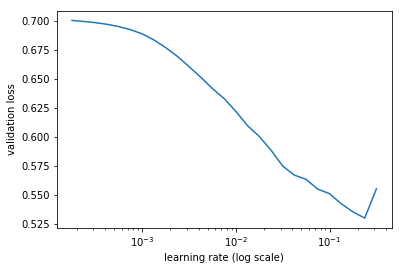

In [50]:
learn.lr_find()
learn.sched.plot()

In [51]:
lr=1e-2
wd=1e-7
lrs = np.array([lr/6,lr/13,lr])/2
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.334284   0.282102   0.877999  
    1      0.260443   0.237197   0.895206                  
    2      0.234707   0.23046    0.900609                  
    3      0.220858   0.22566    0.898326                  


[array([0.22566]), 0.8983262379964193]

In [52]:
learn.fit(lr,2,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.220903   0.244875   0.886906  
    1      0.225072   0.237084   0.898549                  
    2      0.213301   0.233293   0.902839                  
    3      0.204142   0.233824   0.897341                  
    4      0.195675   0.230364   0.89768                   
    5      0.192522   0.253849   0.896689                  
    6      0.197381   0.246378   0.894537                  
    7      0.190832   0.238787   0.899475                  
    8      0.183743   0.241869   0.898554                  
    9      0.176011   0.245982   0.89827                   


[array([0.24598]), 0.8982696533203125]

In [53]:
lr=1e-3
wd=1e-7
learn.fit(lr,2,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.15883    0.246812   0.897602  
    1      0.159308   0.243812   0.900831                  
    2      0.157211   0.248004   0.901397                  
    3      0.154252   0.252813   0.900641                  
    4      0.151027   0.254629   0.89824                   
    5      0.150557   0.256104   0.900446                  
    6      0.150373   0.257741   0.901497                  
    7      0.14872    0.255869   0.897737                  
    8      0.146214   0.261983   0.898469                  
    9      0.143641   0.260964   0.899018                  


[array([0.26096]), 0.8990184466044108]

In [54]:
learn.unfreeze()

In [72]:
learn.fit(lr,3,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>                  
    0      0.133481   0.269956   0.897953  
    1      0.139552   0.267257   0.900901                  
    2      0.13663    0.272639   0.898806                  
    3      0.132226   0.267163   0.901508                  
    4      0.125161   0.269153   0.901061                  
    5      0.123239   0.270237   0.900236                  
    6      0.127222   0.283754   0.894972                  
    7      0.127058   0.270636   0.899065                  
    8      0.12302    0.270123   0.899879                  
    9      0.117679   0.276615   0.901576                  
    10     0.114408   0.286599   0.89857                   
    11     0.115248   0.29245    0.90027                   
    12     0.115749   0.281001   0.899257                  
    13     0.112214   0.285221   0.900831                  
    14     0.107198   0.293037   0.900953                  


[array([0.29304]), 0.9009528160095215]

In [56]:
x,y = next(iter(data.val_dl))
py = to_np(learn.model(V(x)))

In [58]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

(32, 128, 128, 3)

In [245]:
py[num].shape

(128, 128)

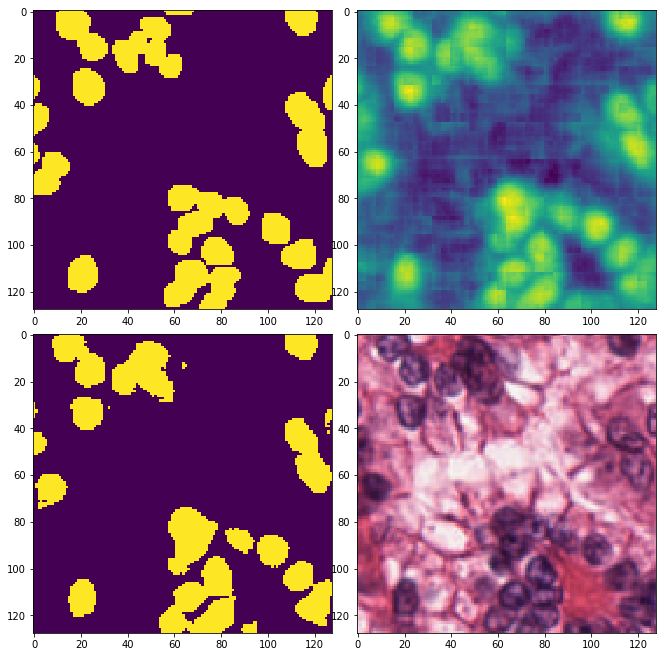

In [249]:
num = 9
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes[0,0].imshow(y_num)
axes[0,1].imshow(py[num])
axes[1,0].imshow(py[num]>0)
axes[1,1].imshow(x_numpy[num])
plt.tight_layout(pad=0.1)

In [73]:
learn.save('monuseg_128Dec12')

In [74]:
x,y = next(iter(data.val_dl))
py = to_np(pre(V(x)))

In [83]:
type(x)

torch.cuda.FloatTensor

In [84]:
x.shape

torch.Size([32, 3, 128, 128])

In [76]:
type(py)

numpy.ndarray

In [77]:
py.shape

(32, 128, 128)

In [79]:
py[0]

array([[-0.40378, -0.06245,  0.41519, ..., -5.08501, -5.10512, -5.01749],
       [-0.68547, -0.32653, -0.02136, ..., -5.21338, -5.26299, -5.09345],
       [-0.77762, -0.58895, -0.62395, ..., -4.59177, -4.89386, -4.77376],
       ...,
       [-4.10907, -3.45718, -2.63824, ..., -3.9342 , -3.83338, -3.61441],
       [-3.77678, -3.18414, -2.62867, ..., -3.91385, -3.88541, -3.52135],
       [-4.03812, -3.43249, -2.65303, ..., -4.0322 , -3.92551, -3.53341]], dtype=float32)

## Predict on a single 128 image

In [285]:
num = 400
img = cv2.imread(wsi_names[num])
img.shape

(128, 128, 3)

In [286]:
trn_tfms,val_tfms = tfms_from_model(stats, 128)
ds=FilesIndexArrayDataset([wsi_names[num]],np.array([0]),val_tfms, path='')
dl=DataLoader(ds)


In [287]:
preds = learn.predict_dl(dl)

In [288]:
type(preds),preds.shape

(numpy.ndarray, (1, 128, 128))

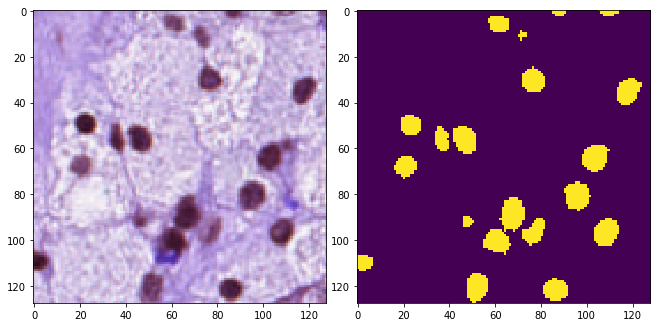

In [289]:
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
axes[0].imshow(img)
axes[1].imshow(preds[0]>0)
plt.tight_layout(pad=0.1)


## Prediction on a larger Image 

In [357]:
wsi_250_path = path + 'tissue250/'
mask_large_path = path +'NucCentroids/'

In [358]:
wsi_250 = glob.glob(wsi_250_path + '*.tif')
mask_large = glob.glob(mask_large_path + '*.png')

In [361]:
num = 25
img=Image.open(wsi_250[num]).resize((128,128))


In [362]:
trn_tfms,val_tfms = tfms_from_model(stats, 128)
ds=FilesIndexArrayDataset([wsi_250[num]],np.array([0]),val_tfms, path='')
dl=DataLoader(ds)


In [363]:
preds = learn.predict_dl(dl)

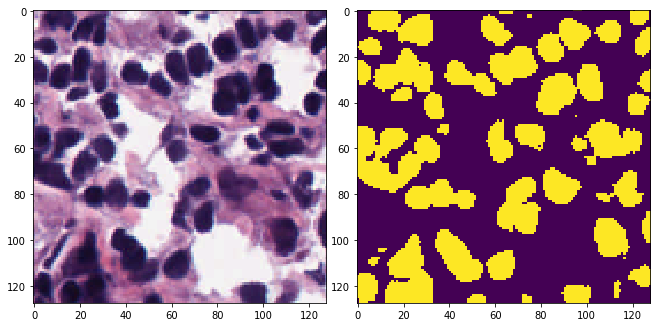

In [364]:
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
axes[0].imshow(img)
axes[1].imshow(preds[0]>0)
plt.tight_layout(pad=0.1)


In [368]:
wsi_500_path = path + 'tissue500/'
wsi_500 = glob.glob(wsi_500_path + '*.tif')

In [369]:
num = 10
img=Image.open(wsi_500[num]).resize((128,128))

In [370]:
trn_tfms,val_tfms = tfms_from_model(stats, 128)
ds=FilesIndexArrayDataset([wsi_500[num]],np.array([0]),val_tfms, path='')
dl=DataLoader(ds)


In [371]:
preds = learn.predict_dl(dl)

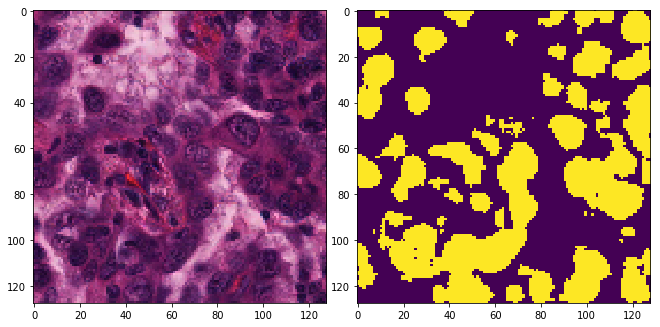

In [372]:
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
axes[0].imshow(img)
axes[1].imshow(preds[0]>0)
plt.tight_layout(pad=0.1)

In [373]:
wsi_1000_path = path + 'TissueImages/'
wsi_1000 = glob.glob(wsi_1000_path + '*.tif')


In [374]:
num = 10
img=Image.open(wsi_1000[num]).resize((128,128))

In [378]:
trn_tfms,val_tfms = tfms_from_model(stats, 128)
ds=FilesIndexArrayDataset([wsi_1000[num]],np.array([0]),val_tfms, path='')
dl=DataLoader(ds)


In [379]:
preds = learn.predict_dl(dl)

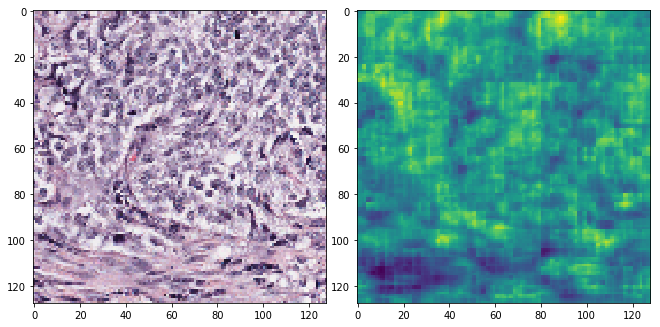

In [381]:
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(1, 2, figsize=(9, 9))
axes[0].imshow(img)
axes[1].imshow(preds[0])
plt.tight_layout(pad=0.1)

## Train on 500 Set Mask Not BW

In [444]:
wsi_500_path = path + 'tissue500/'
mask_500_path=path+'bwmask500/'

In [389]:
wsi_names2=glob.glob(wsi_500_path+'*.tif')


In [448]:
mask_names2=[path+'bwmask500/' +os.path.basename(x) for x in wsi_names2]

In [449]:
mask_names2[:5]

['data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask500/TCGA-G2-A2EK-3.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask500/TCGA-50-5931-2.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask500/TCGA-50-5931-1.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask500/TCGA-AR-A1AK-0.tif',
 'data/BreathPathQ/jr-breastpathq/datasets/MoNuSegTraining/bwmask500/TCGA-HE-7130-3.tif']

In [390]:
len(wsi_names2),len(mask_names2)

(120, 120)

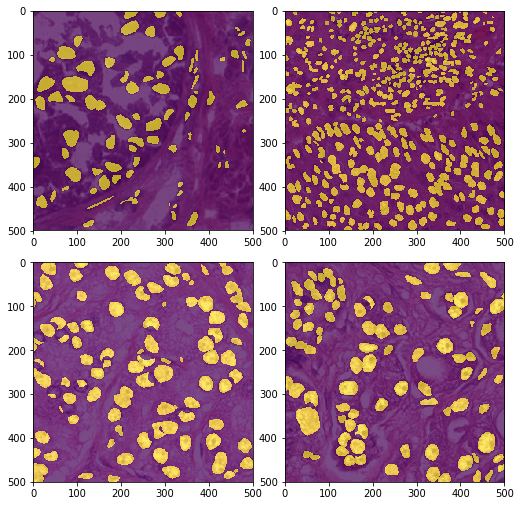

In [450]:
_, axes = plt.subplots(2, 2, figsize=(7, 7))
for i,ax in enumerate(axes.flat):
    #pdb.set_trace()
    img=plt.imread(wsi_names2[i*4])
    ax.imshow(img)
    mask=plt.imread(mask_names2[i*4]); 
    ax.imshow(mask, alpha=0.7) 
plt.tight_layout(pad=0.1)

In [409]:
n=len(wsi_names2)
val_idxs = get_cv_idxs(n)
val_idxs[:5]

array([44, 47,  4, 55, 26])

In [454]:
val_x= [wsi_names2[o] for o  in val_idxs]
trn_x = [wsi_names2[o] for o  in range(n) if o not in val_idxs]

val_y=  [mask_names2[o] for o  in val_idxs]
trn_y = [mask_names2[o] for o  in range(n) if o not in val_idxs]

In [411]:
wsi_allmean_trn = np.mean([wsimean[i] for i in range(n) if i not in val_idxs],axis=0)
wsi_allstd_trn = np.std([wsistd[i] for i in range(n) if i not in val_idxs],axis=0)

In [417]:
stats = (wsi_allmean_trn,wsi_allstd_trn)
stats

(array([174.89694, 124.84474, 161.20528]),
 array([10.51465, 12.70506,  9.68108]))

In [425]:
aug_tfms = [RandomRotate(10, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05)]

In [419]:
def get_data(sz,bs):
    tfms = tfms_from_model(stats, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    #dataloader has continuous=True option for regression model 
    #Treat this problem as a classification 
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    data = ImageData('', datasets, bs, num_workers=8, classes=None)
    return data

In [455]:
data = get_data(256,32)

In [456]:
x,y = next(iter(data.trn_dl))
x = data.trn_ds.denorm(x)

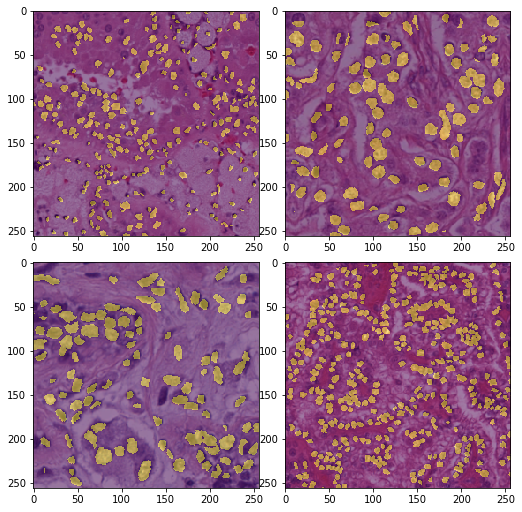

In [458]:
fig, axes = plt.subplots(2, 2, figsize=(7, 7))
for i,ax in enumerate(axes.flat):
    #pdb.set_trace()
    ax.imshow(x[i*4])
    ax.imshow(y[i*4], alpha=0.5) 
plt.tight_layout(pad=0.1)

In [459]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [460]:
learn.load('monuseg_128Dec12')


In [461]:
learn.freeze_to(1)

In [462]:
learn.fit(lr,3,wds=wd, cycle_len=5,use_clr=(5,5))

epoch      trn_loss   val_loss   <lambda>                
    0      0.30507    0.282958   0.874866  
    1      0.285281   0.278833   0.864904                
    2      0.275236   0.268343   0.869289                
    3      0.266252   0.26102    0.879601                
    4      0.260584   0.259199   0.880898                
    5      0.256108   0.255467   0.877386                
    6      0.253224   0.24992    0.880068                
    7      0.250241   0.248175   0.888087                
    8      0.24766    0.246559   0.884439                
    9      0.24532    0.248052   0.881776                
    10     0.243339   0.2443     0.884681                
    11     0.241665   0.242855   0.886097                
    12     0.240073   0.243443   0.883038                
    13     0.238516   0.241676   0.88632                 
    14     0.237165   0.241385   0.886925                


[array([0.24139]), 0.8869253993034363]

In [463]:
learn.unfreeze()
learn.bn_freeze(True)

In [464]:
lrs=np.array([lr/200,lr/300,lr])

In [465]:
learn.fit(lrs,3,wds=wd, cycle_len=5,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>                
    0      0.225907   0.24328    0.884864  
    1      0.225493   0.239611   0.89083                 
    2      0.225066   0.238199   0.886148                
    3      0.224465   0.237451   0.886709                
    4      0.224241   0.237325   0.887392                
    5      0.223846   0.238849   0.889569                
    6      0.223718   0.241193   0.887241                
    7      0.223458   0.241625   0.88584                 
    8      0.223452   0.241013   0.885881                
    9      0.223194   0.240002   0.886823                
    10     0.222983   0.237204   0.889472                
    11     0.222876   0.236338   0.887822                
    12     0.222804   0.235977   0.888854                
    13     0.222527   0.236215   0.889212                
    14     0.222321   0.23647    0.889327                


[array([0.23647]), 0.8893267512321472]

In [466]:
learn.save('monuseg_256Dec12')

train with size 512 

In [489]:
data = get_data(512,1)

In [490]:
x,y = next(iter(data.trn_dl))
x = data.trn_ds.denorm(x)

In [485]:
learn = ConvLearner(data, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5)]

In [486]:
learn.load('monuseg_256Dec12')

In [487]:
learn.freeze_to(1)

In [492]:
learn.fit(lr,3,wds=wd, cycle_len=5,use_clr=(5,5))

  0%|          | 0/6 [00:00<?, ?it/s]

RuntimeError: cuda runtime error (2) : out of memory at /opt/conda/conda-bld/pytorch_1518244421288/work/torch/lib/THC/generic/THCStorage.cu:58

In [467]:
x,y = next(iter(data.val_dl))
py = to_np(learn.model(V(x)))

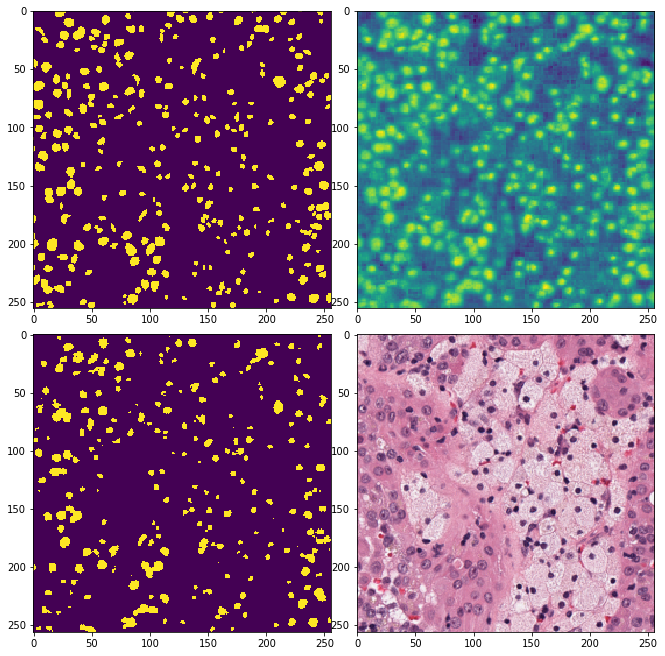

In [468]:
num = 9
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(2, 2, figsize=(9, 9))
axes[0,0].imshow(y[num])
axes[0,1].imshow(py[num])
axes[1,0].imshow(py[num]>0)
axes[1,1].imshow(x_numpy[num])
plt.tight_layout(pad=0.1)

Prediction on the 1000 pixel images

In [373]:
wsi_1000_path = path + 'TissueImages/'
wsi_1000 = glob.glob(wsi_1000_path + '*.tif')


In [469]:
num = 10
sz=256
img=Image.open(wsi_1000[num]).resize((sz,sz))

In [470]:
trn_tfms,val_tfms = tfms_from_model(stats, 128)
ds=FilesIndexArrayDataset([wsi_1000[num]],np.array([0]),val_tfms, path='')
dl=DataLoader(ds)


In [471]:
preds = learn.predict_dl(dl)

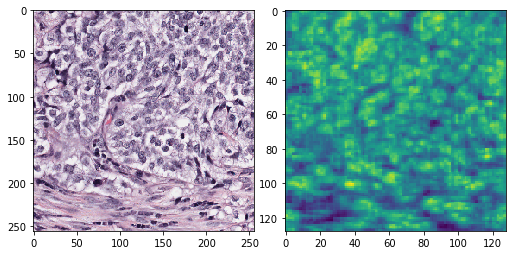

In [474]:
x_numpy = data.trn_ds.denorm(x)
fig, axes = plt.subplots(1, 2, figsize=(7, 7))
axes[0].imshow(img)
axes[1].imshow(preds[0])
plt.tight_layout(pad=0.1)